# TP 2 de Video Processing

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import yaml
import itertools

In [2]:
PATH_TO_IMG_DIRECTORY = '../images/'
PATH_TO_CONFIG_FILE = '../config.yml'

Fonctionnalités pour des configurations externes.

In [3]:
def read_yaml(file_name):
    with open(file_name, 'r') as fichier:
        contenu = fichier.read()
        donnees = yaml.safe_load(contenu)
    return donnees

def write_yaml(data, nom_fichier):
    with open(nom_fichier, 'w') as fichier:
        contenu = yaml.dump(data, default_flow_style=False)
        fichier.write(contenu)

## **Question (A)**
Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre $F1$ et $F2$.

Procédez maintenant à de l’estimation backward par blocs entre $F1$ et $F2$.

In [4]:
def load_img_array(img_path :str) -> np.ndarray :
    img = Image.open(img_path)
    return np.asarray(img)

In [5]:
# Thank you Mister Medjkoune for those functions 

def display_image(array, now = True, vmin = None, vmax = None, title='',figsize=(20,10)):
    """Display 2D array as image"""
    fig, ax = plt.subplots(figsize =figsize)
    plt.imshow(array, cmap = plt.cm.gray, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    if now:
        plt.title(title)
        plt.show()
def display_images(images, lines = None, columns = None, indices = None, vmin = None, vmax = None):
    """Display a list of 2D arrays as images
    """
    if columns is None:
        if lines is None:
            columns = int(np.ceil(np.sqrt(len(images))))
        else:
            columns = int(np.ceil(float(len(images)) / lines))
    if lines is None:
        lines = int(np.ceil(float(len(images)) / columns))
    if indices is None:
        indices = range(1, len(images) + 1)
    for k in range(len(images)):
        if not images[k] is None:
            plt.subplot(lines, columns, indices[k])
            display_image(images[k], vmin = vmin, vmax = vmax, now = False)
    plt.show()

In [6]:
img_1_file_path = os.path.join(PATH_TO_IMG_DIRECTORY,'1.png')
img_2_file_path = os.path.join(PATH_TO_IMG_DIRECTORY,'2.png')

Affichage des images

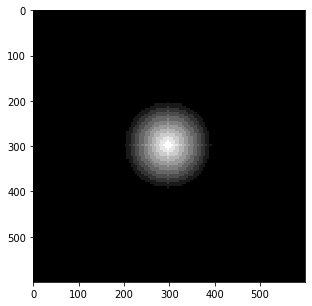

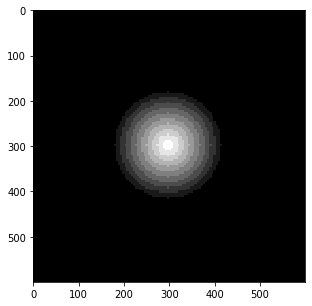

In [7]:
f1 = load_img_array(img_1_file_path)
f2 = load_img_array(img_2_file_path)
display_image(f1,figsize=(5,5))
display_image(f2,figsize=(5,5))

Définition de la classe qui sera en charge de reconstruire l'image $F2$ avec l'estimation backward.

In [113]:
class BackWardEstimator():
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ,block_size:int = 25, window_size=20) -> None:
        """Classe dédiée pour l'estimation backward selon une taille de bloc et une taille de fenêtre.

        Args:
            frame_1_file_name (str): Chemin vers la frame 1
            frame_2_file_name (str): Chemin vers la frame 2
            block_size (int, optional): Rayon du bloc mis par défaut à 25
            window_size (int, optional): Taille de la fenêtre d'analyse misz par défaut à 20.
        """
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.f2 = np.asarray(img2)
        self.f1 = np.asarray(img1)
        self.window_size = window_size
        self.block_size = block_size
        self.flow_vectors = []
        self.epsilon = None
        self.predicted_f2 = None
        self.reconstructed_f2 = None
    
    def get_min_error_block(self,x :int,y:int,show_block = False) -> tuple:
        """Fonction qui minimise l'EDFD

        Args:
            `x` (int): Abscisse du centre du bloc.
            `y` (int): Ordonnée du centre du bloc.
            show_block (bool, optional): Option de debug.

        Returns:
            tuple: Coordonnées du point et du vecteur qui minimise l'EDFD.
        """
        height, width = self.f2.shape[:2]
        
        # On définit les limites des coordonnées.
        left_x_bound = max(x-self.block_size-self.window_size,0)
        right_x_bound = min(x+self.block_size+self.window_size,height-self.block_size)
        left_y_bound = max(y-self.block_size-self.window_size,0)
        right_y_bound = min(y+self.block_size+self.window_size,width-self.block_size)
        # On prend notre bloc de référence dans F2.
        current_block = self.f2[x-self.block_size:x+self.block_size,y-self.block_size:y+self.block_size].astype(int)
        min_cost = float('inf')
        min_dist = float('inf')
        best_match = (0,0,0,0)
        for i in range(left_x_bound,right_x_bound):
            for j in range(left_y_bound,right_y_bound):
                prev_block = self.f1[i-self.block_size:i+self.block_size,j-self.block_size:j+self.block_size].astype(int)
                # On vérifie la compatibilité des blocs.
                if current_block.shape != prev_block.shape :
                    continue
                
                cost = np.sum(np.abs(current_block - prev_block))
                dist = abs(x-i) + abs(y-j)
                # Mise à jour du vecteur minimisant l'EDFD si la distance est plus proche de notre bloc de référence.
                if (cost  == min_cost and dist < min_dist):
                    best_match = (x,y,i-x,j-y)
                    min_dist = dist
                # Mise à jour du vecteur minimisant l'EDFD indépendamment de la distance
                if(cost < min_cost):
                    min_cost = cost
                    best_match = (x,y,i-x,j-y)
    
        return best_match
    
    def back_ward_estimation(self) -> np.ndarray :
        """Méthode qui applique l'estimation de mouvement backward

        Returns:
            np.ndarray: Image avec le champs de vecteur backward.
        """
        height, width = self.f2.shape[:2]
        for x in tqdm(range(self.block_size,height-self.block_size+1,2*self.block_size)):
            for y in (range(self.block_size,width-self.block_size+1,2*self.block_size)):
                best_match = self.get_min_error_block(x,y)
                self.flow_vectors.append(best_match)
                
        img_to_display = np.copy(self.f2)
        for point in self.flow_vectors:
            x,y,dx,dy = point
            # Affichage de l'image avec les vecteur.
            cv2.arrowedLine( img_to_display,(y,x), (int(dy+y),int(dx+x)), (255, 0, 0),1)
        
        print(f'Backward estimation by block wise method with {self.block_size} for block size and {self.window_size} for window size.')
        return img_to_display
    
    def display_backward_estimation(self)-> None:
        """Affiche l'estimation de mouvement backward.
        """
        img_to_display = self.back_ward_estimation()
        display_image(img_to_display,title='Backward Motion Estimation')
        
    def predict_f2(self,display=True) -> np.ndarray:
        """Prédiction de F2 en fonction de F1 et du champ de vecteur backward.
        Args:
            display (bool, optional): Précise s'il on affiche ou pas l'image prédite

        Returns:
            np.ndarray: Image à prédire
        """
        new_img = np.zeros(shape=self.f1.shape,dtype=np.uint8)
        if (len(self.flow_vectors) == 0):
            self.back_ward_estimation()
        # Pour chaque vecteur de l'estimation de mouvement backward on applique la procédure suivante:
        for vec in self.flow_vectors:
            x,y,dx,dy = vec
            f1_x = x+dx
            f1_y = y+dy 
            block_size = self.block_size
            # On récupère le block de f1 qui subit une translation lié à `vec`
            block_1 =  self.f1[f1_x-block_size:f1_x+block_size:,f1_y-block_size:f1_y+block_size]
            # On affecte le nouveau bloc dans l'image à prédire
            new_img[x-block_size:x+block_size,y-block_size:y+block_size] = block_1
        
        if(display):
            display_image(new_img,title='Reconstituted F2')
        self.predicted_f2 = new_img
        return new_img
    
    def get_predicted_f2(self)-> np.ndarray:
        """Renvoie la prédiction de F2
        Returns:
            np.ndarray: Prédiction de F2 par calculée par la backward estimation.
        """
        if (self.predicted_f2 is None):
            self.predict_f2(display=False)
        return self.predicted_f2
    
    def get_epsilon(self) -> np.ndarray:
        """Renvoie l'erreur epsilon = F2 - F2'

        Returns:
            np.ndarray: epsilon
        """
        
        return self.f2.astype(int) - self.get_predicted_f2().astype(int)
    
    def get_mse(self)->float:
        """Méthode qui calcule l'erreur moyenne quadratique(MSE).

        Returns:
            float: MSE
        """
        return np.mean(np.square(self.get_predicted_f2().astype(int) - self.f2.astype(int)))
    
    def get_reconstruct_f2(self,display:bool = False) -> np.ndarray:
        """Méthode qui consiste à recontruire F2 à partir de F1, du champs de vecteur et d'epsilon

        Returns:
            np.ndarray: F2 reconstruite
        """
        if(self.reconstructed_f2 is None):
            self.reconstructed_f2 = self.get_predicted_f2() + self.get_epsilon()
        if (display):
            display_image(self.reconstructed_f2)
        return self.reconstructed_f2
    
    def __call__(self,display:bool = True) -> np.ndarray:
        """Lancment de l'estimation backward, elle enregistre les vecteurs de mouvement.

        Args:
            display (bool, optional): 

        Returns:
            np.ndarray: Image F2 avec les champs de vecteur
        """
        if (display):
            return self.display_backward_estimation()
        return self.back_ward_estimation()

block_size,window_size=(20, 20)


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:23<00:00,  1.57s/it]

Backward estimation by block wise method with 20 for block size and 20 for window size.


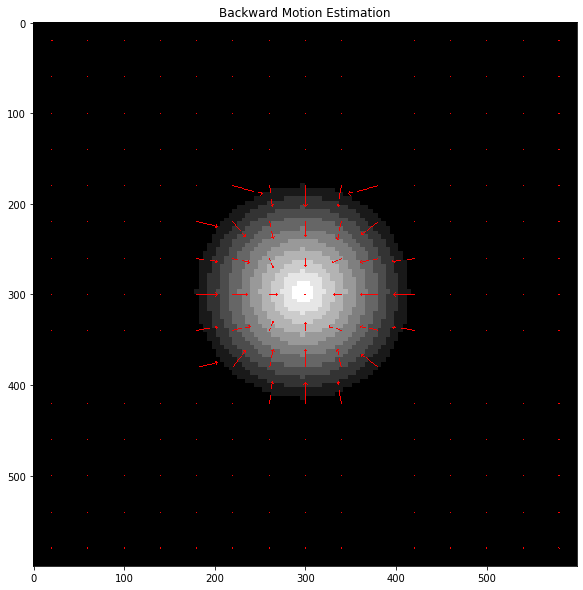

In [131]:
backward_estimator = BackWardEstimator(img_1_file_path,img_2_file_path,block_size=20,window_size=20)
backward_estimator()

In [123]:
def search_best_hyper_params(img_1_file_path,img_2_file_path):
    parameters = {
        'block_size': [10,15,20,25,30,35],
        'window_size': [10,20,25],
    }

    grid = list(itertools.product(*parameters.values()))
    best_mse = float('inf')
    best_param = {}
    for params in tqdm(grid):
        param_dict = dict(zip(parameters.keys(), params))
        cur_backward_estimator = BackWardEstimator(img_1_file_path,img_2_file_path,**param_dict)
        mse = cur_backward_estimator.get_mse()
        if(mse < best_mse):
            best_param = param_dict
            best_mse = mse
    
    return best_param, best_mse


  0%|          | 0/18 [00:00<?, ?it/s]

block_size,window_size=(10, 10)


  6%|▌         | 1/18 [00:15<04:26, 15.70s/it]

Backward estimation by block wise method with 10 for block size and 10 for window size.
block_size,window_size=(10, 20)


 11%|█         | 2/18 [00:50<07:14, 27.14s/it]

Backward estimation by block wise method with 10 for block size and 20 for window size.
block_size,window_size=(10, 25)


 17%|█▋        | 3/18 [01:38<09:10, 36.68s/it]

Backward estimation by block wise method with 10 for block size and 25 for window size.
block_size,window_size=(15, 10)


 22%|██▏       | 4/18 [01:51<06:20, 27.16s/it]

Backward estimation by block wise method with 15 for block size and 10 for window size.
block_size,window_size=(15, 20)


 28%|██▊       | 5/18 [02:16<05:43, 26.45s/it]

Backward estimation by block wise method with 15 for block size and 20 for window size.
block_size,window_size=(15, 25)


 33%|███▎      | 6/18 [02:50<05:47, 28.94s/it]

Backward estimation by block wise method with 15 for block size and 25 for window size.
block_size,window_size=(20, 10)


 39%|███▉      | 7/18 [03:03<04:20, 23.67s/it]

Backward estimation by block wise method with 20 for block size and 10 for window size.
block_size,window_size=(20, 20)


 44%|████▍     | 8/18 [03:26<03:54, 23.46s/it]

Backward estimation by block wise method with 20 for block size and 20 for window size.
block_size,window_size=(20, 25)


 50%|█████     | 9/18 [03:53<03:42, 24.67s/it]

Backward estimation by block wise method with 20 for block size and 25 for window size.
block_size,window_size=(25, 10)


 56%|█████▌    | 10/18 [04:06<02:49, 21.13s/it]

Backward estimation by block wise method with 25 for block size and 10 for window size.
block_size,window_size=(25, 20)


 61%|██████    | 11/18 [04:29<02:31, 21.63s/it]

Backward estimation by block wise method with 25 for block size and 20 for window size.
block_size,window_size=(25, 25)


 67%|██████▋   | 12/18 [04:57<02:21, 23.54s/it]

Backward estimation by block wise method with 25 for block size and 25 for window size.
block_size,window_size=(30, 10)


 72%|███████▏  | 13/18 [05:12<01:44, 20.88s/it]

Backward estimation by block wise method with 30 for block size and 10 for window size.
block_size,window_size=(30, 20)


 78%|███████▊  | 14/18 [05:35<01:26, 21.73s/it]

Backward estimation by block wise method with 30 for block size and 20 for window size.
block_size,window_size=(30, 25)


 83%|████████▎ | 15/18 [06:03<01:10, 23.48s/it]

Backward estimation by block wise method with 30 for block size and 25 for window size.
block_size,window_size=(35, 10)


 89%|████████▉ | 16/18 [06:19<00:42, 21.15s/it]

Backward estimation by block wise method with 35 for block size and 10 for window size.
block_size,window_size=(35, 20)


 94%|█████████▍| 17/18 [06:42<00:21, 21.86s/it]

Backward estimation by block wise method with 35 for block size and 20 for window size.
block_size,window_size=(35, 25)


100%|██████████| 18/18 [07:10<00:00, 23.93s/it]

Backward estimation by block wise method with 35 for block size and 25 for window size.


({'block_size': 10, 'window_size': 20}, 8.739394444444445)

|**Observations:** |**Interprétations:** | 
| :- | :- |
|On remarque que sur le fond noir les vecteurs sont nuls | Cela s'explique par une absence de mouvement entre les deux frames | 
|Au niveau du cercle les vecteur s'orientent tous vers le centre de l'image | Cela témoigne du rétrécissement du cercle de la frame 2 à la frame 1| 

## **Question (B)**
* Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ?
    
    On veut connaitre la frame de F2 à partir de F1, il convient donc de connaitre l'estimation de mouvement de F2 vers F1.

* Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)
    
    Nous aurions obtenu sûrement une estimation de mouvement incohérente, et du bruit dans l'image.

## **Question (C)**
Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?


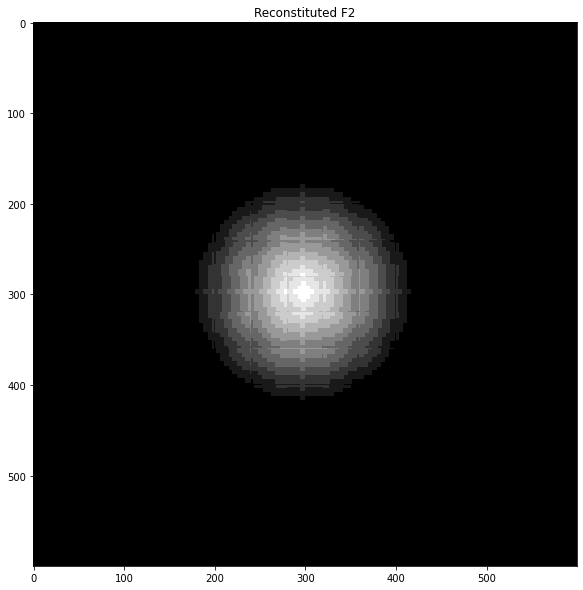

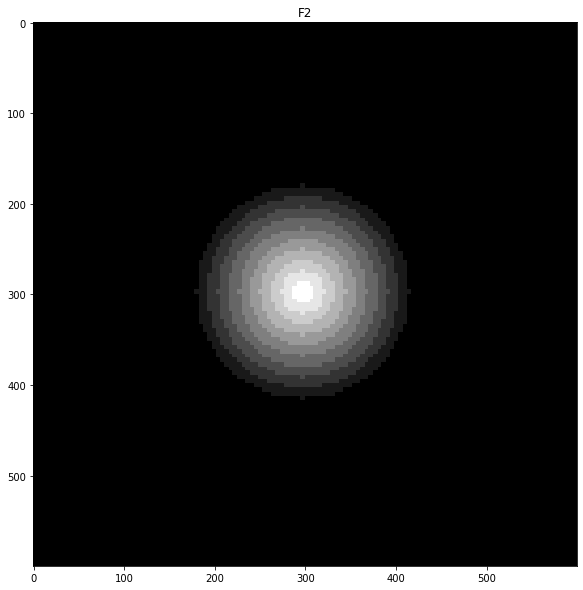

Mean squared error = 17.232266666666668


In [132]:
predicted_f2 = backward_estimator.predict_f2()
display_image(backward_estimator.f2, title='F2',figsize=(10,10))
mse = backward_estimator.get_mse()
print(f'Mean squared error = {mse}')


**Observations:**
- Le rayon des cercles lumineux pour F2 et F2 predite sont similaires.
- Le centre de F2 prédite possède une trace légèrement quadrillée au centre.
- L'affichage de la différence entre F2 et F2 predite montre tout de même du bruit au niveau de la reconstitution du cercle.
- Le fond noir reste constant.
- La MSE ne semble pas témoigner d'une grande différence entre F2 et F2 predite.

## **Question (D)**
Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?


Il faut:
-  Le champ de vecteur de l'estimation backward
- L'erreur $\epsilon$ entre $F_1$ et $F_2$
- L'image $F_1$

## **Question (E)**
Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

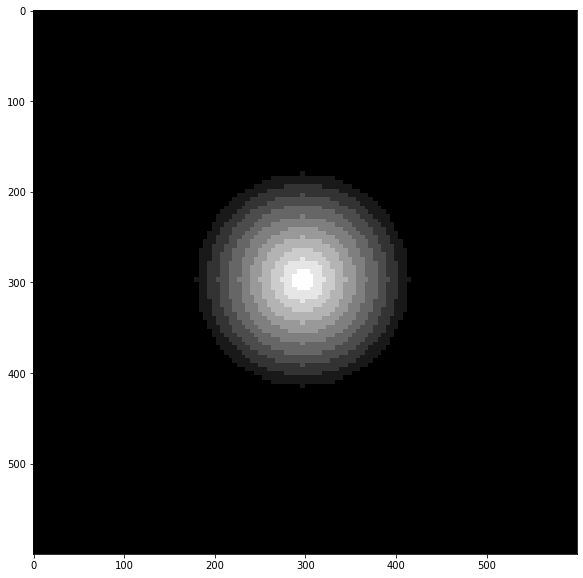

In [126]:
backward_estimator.get_reconstruct_f2(display=True);

In [12]:
mse = np.mean(np.square(backward_estimator.get_reconstruct_f2() - backward_estimator.f2))
print(f'Mean squared error = {mse}')

Mean squared error = 0.0


## **Question (F)**
Expliquez quelles données on peut coder avec perte pour garder une
qualité de reconstruction de $F1$ et $F2$ ”correcte”. Justifiez vos explications par des images de rendus.

**Explications:**

On peut d'abord appliquer à $F1$ la DCT (Transformée en Cosinus Discrète) qui va donner des coefficients des fréquences les plus élevées. Enfin les coefficients seront quantifiés en réduisant leur précision en les divisant par des valeurs prédéfinies dans une matrice de quantification. 

On peut coder $\varepsilon$ de la même manière que $F1$. Cependant le codage de $\varepsilon$ est plus avantageux car elle possède beaucoup de redondance en terme de données, comme on peut le voir ci-dessous

On remarque aussi que le champs de vecteurs peut posséder des vecteurs nuls, afin de faciliter la compression on ne peut que garder les vecteurs non nuls. Pour rappel les vecteur manipulés se présente comme suit : $(x,y,d_x,d_y)$
avec $(x,y)$ les coordonées du point de départ du bloc dans $F2$ et $(d_x,d_y)$ les coordonnées de translation du vecteur.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


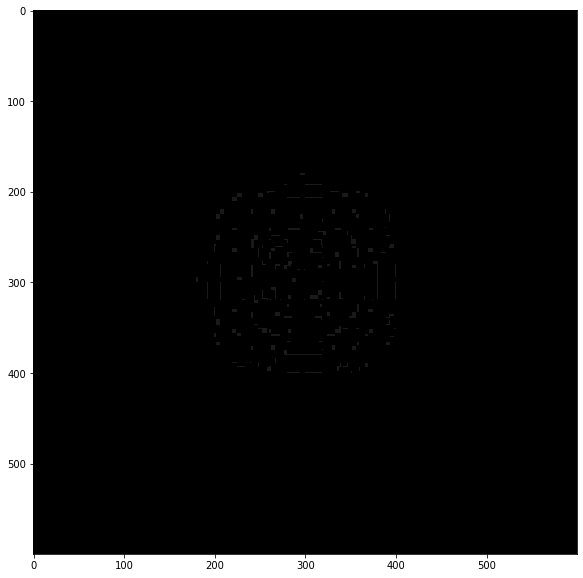

In [127]:
display_image(backward_estimator.get_epsilon())

On observe une prédominance de pixels noir et quelques pixels gris similaires et on peut observer une faible diversité des données quand on fait un histogramme des valeurs de $\varepsilon$

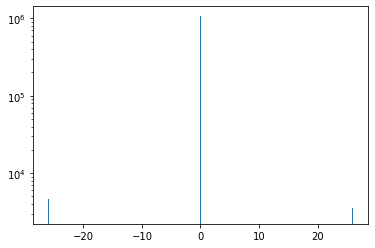

In [128]:
epsilon:np.ndarray = backward_estimator.get_epsilon()
plt.hist(epsilon.flatten(),bins=255*2)
plt.yscale('log')


In [130]:
unique_values, counts = np.unique(epsilon, return_counts=True)
df = pd.DataFrame({'Valeurs': unique_values, 'Occurences': counts})
df

,Valeurs,Occurences
0,-26,4587
1,-25,2976
2,0,1065561
3,25,3342
4,26,3534


On peut remarquer la faible diversité des données de $\varepsilon$, il est donc avantageux de la coder.
|Avant la compression| Après la compression|
|:-|:-|
|$F1$|$F1$ codée avec DCT|
|$\varepsilon$ d'une taille similaire à $F1$|$\varepsilon$ codée avec DCT|
|Champs de vecteur block-wise|Champs de vecteur block-wise|

## **Question (G)**
Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


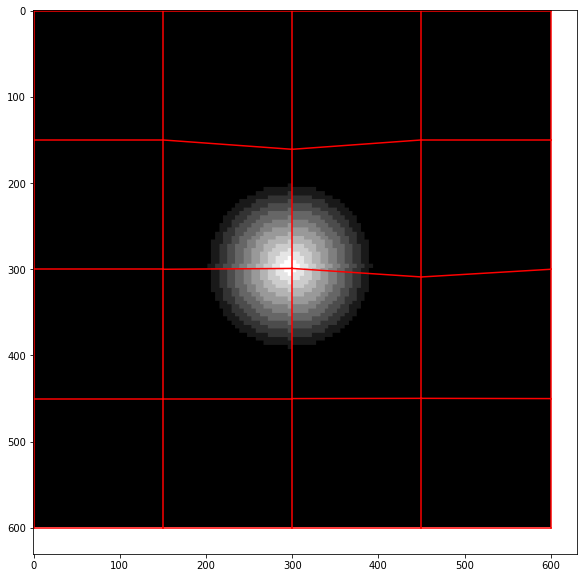

In [86]:
class MeshBlock:
    def __init__(self,x:int,y:int,size:int) -> None:
    
        # Coordonées du bloc ayant une forme supposée carrée.
        self.x = x 
        self.y = y
        self.size = size 
        # Initialisation d'un tableau phi_k qui va contenir les coefficient des d_k
        self.phi_k = np.zeros(shape=(4))
        # self.init_nodes()
        self.mesh_nodes = []
        self.EDFD = -1
   
    
    def get_phi_k(self,x:int,y:int):
        x_max = self.x+self.size
        y_max = self.y+self.size
        constant = (x_max - self.x)*(y_max - self.y)
        self.phi_k[0]=((x_max - x)*(y_max - y)/constant)
        self.phi_k[1]=((x - self.x)*(y_max - y)/constant)
        self.phi_k[2]=((x - self.x)*(y - self.y)/constant)
        self.phi_k[3]=((x_max - x)*(y - self.y)/constant)
        return self.phi_k
    
    def get_d_vector(self,x:int, y:int) -> tuple:
        """
        Génère le vecteur d en faisant la somme pondérée des phi_k et d_k.
        """
        self.get_phi_k(x,y)
        x_d,y_d =0,0
        for i in range(4):
            x_d+= self.mesh_nodes[i].d_vector[0] * self.phi_k[i]
            y_d+= self.mesh_nodes[i].d_vector[1] * self.phi_k[i]
        return int(x_d),int(y_d)
    
    def __str__(self) -> str:
        return f'{[(str(node)) for node in self.nodes]}'



class MeshBasedEstimator:
    def __init__(self, frame_1_file_name :str, frame_2_file_name,  block_size: int = 10,learning_rate:float = 1e-6) -> None:
        
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.f2 = np.asarray(img2)
        self.f1 = np.asarray(img1)
        assert self.f1.shape == self.f2.shape
        self.learning_rate = learning_rate
        self.block_size = block_size
        self.init_blocks()
        
    def init_blocks(self):
        """Initialise les blocs"""
        height,width = self.f1.shape[0:2]
        rows = height//self.block_size
        cols = width//self.block_size
        self.blocks_array = np.ndarray(shape=(rows,cols),dtype=MeshBlock)
        self.node_array = np.ndarray(shape=(rows+1,cols+1,2))
        for i in range(self.blocks_array.shape[0]):
            for j in range(self.blocks_array.shape[1]):
                x,y =self.block_size*i,self.block_size*j
                current_block = MeshBlock(x,y,self.block_size)
                self.blocks_array[i,j] = current_block
                for k in (0,1):
                    for l in (0,1):
                        self.node_array[i+k,j+l] = np.zeros(shape=(2))
                
     
    def psi_1(self,x:int,y:int) -> int:
        """
        Méthode qui détermine la luminescence de la frame 1.
        """
        if(x >= self.f1.shape[0] or y >= self.f1.shape[1]):
            return 0
        if(x < 0 or y < 0):
            return 0
        return np.sum(self.f1[x,y].astype(int))
    
    def psi_2(self,x:int,y:int) -> int:
        """
        Méthode qui détermine la luminescence de la frame 2.
        """
        if(x >= self.f2.shape[0] or y >= self.f2.shape[1]):
            return 0
        if(x < 0 or y < 0):
            return 0
        return np.sum(self.f2[x,y].astype(int))
    
    def get_EDFD(self,i:int,j:int) -> int:
        """"Calcule l'erreur"""
        error = 0
        block = self.blocks_array[i,j]
        for x in range(block.x,block.x+block.size):
            for y in range(block.y,block.y+block.size):
                vectors = self.node_array[i:i+2,j:j+2].reshape((4,2))
                phi_k = block.get_phi_k(x,y)
                x_d = int(np.sum(vectors[:,0] * phi_k))
                y_d = int(np.sum(vectors[:,1] * phi_k))
                diff = (np.sum( self.psi_2(x=x+x_d,y=y+y_d) - self.psi_1(x=x,y=y)))**2
                error +=diff
            break
        block.EDFD = error
        return error
    def get_d_EDFD(self,i:int,j:int) -> int:
        """" Calcule l'erreur d'un vecteur d """
        error = 0
        for k in range(max(0,i-1), min(i+2,self.node_array.shape[0]-1)):
            for l in range(max(0,j-1), min(j+2,self.node_array.shape[1]-1)):
                block =  self.blocks_array[k,l]
                self.get_EDFD(k,l)
                error += block.EDFD
        return error
    def gradient_descent(self,h:int=2, learning_rate = 1e-5):
        new_node_array = np.copy(self.node_array)
       
        for i in (range(self.node_array.shape[0])):
           
            for j in range(self.node_array.shape[1]):
                edfd = self.get_d_EDFD(i,j) 
                
                for k in (0,1):
                    old_d_n = self.node_array[i,j,k]
                    self.node_array[i,j,k] += h 
                    derivate = (self.get_d_EDFD(i,j) - edfd)/h
                    
                    new_node_array[i,j,k] = old_d_n - derivate * learning_rate
                    self.node_array[i,j,k] = old_d_n
        self.node_array = new_node_array
        return
    
    def plot_nodes (self, ax: plt.Axes = None, fig: plt.Figure = None, color:str ='r') -> tuple:
        """" Méthode pour afficher les noeuds"""
        if(ax is None or fig is None):
            fig, ax = plt.subplots(figsize=(10,10))
        # plt.imshow(self.frame_array_2)
        def get_coord(i,j):
            x1 = i * self.block_size + self.node_array[i,j,0]
            y1 = j * self.block_size + self.node_array[i,j,1]
            return x1,y1
        def plot_cols(i,j,ax):
            x1,y1 = get_coord(i,j)
            x2,y2 = get_coord(i,j+1)
            ax.plot([x1, x2],[y1,y2], color=(1,0,0))
            
        def plot_rows(i,j,ax):
            x1,y1 = get_coord(i,j)
            x2,y2 = get_coord(i+1,j)
            ax.plot([x1, x2],[y1,y2], color=(1,0,0))
            
        ax.imshow(self.f2)
        for i in range(self.node_array.shape[0]):
            for j in range(self.node_array.shape[1]):
                if(j<self.node_array.shape[1]-1):
                    plot_cols(i,j,ax)
                if(i<self.node_array.shape[0]-1):
                    plot_rows(i,j,ax)
                
            
        
        return
        
mbe = MeshBasedEstimator(frame_1_file_name=img_2_file_path,frame_2_file_name=img_1_file_path,block_size=600//4)
for epoch in tqdm(range(25)):
    mbe.gradient_descent(learning_rate=1e-5)
mbe.plot_nodes()

plt.show()

In [85]:
for e,i in enumerate([1,5,6,24,6]):
    print(e,i)

0 1
1 5
2 6
3 24
4 6
